<a href="https://colab.research.google.com/github/dogukartal/IBM_AI_Labs/blob/main/Deep%20Learning%20with%20Keras%20and%20Tensorflow/Self%20Notes/Sequential_Vision_Speech_Decision_Transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Sequential Data Processing**

## Data
---

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN
import numpy as np
import matplotlib.pyplot as plt

def sin_wave(seq_lenght=100):
  x = np.linspace(0, 2*np.pi, seq_lenght)
  y = np.sin(x)
  return y

def prepare_data(data, time_steps, time_window):
  X, Y = [], []
  for i in range(len(data) - time_window):
    X.append(data[i:i + time_window])
    Y.append(data[i + time_window])
  return np.array(X), np.array(Y)

# Data
data = sin_wave()
time_steps = np.arange(len(data))
time_window = 10
X, Y = prepare_data(data, time_steps, time_window)


## Simple RNN Model
---

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


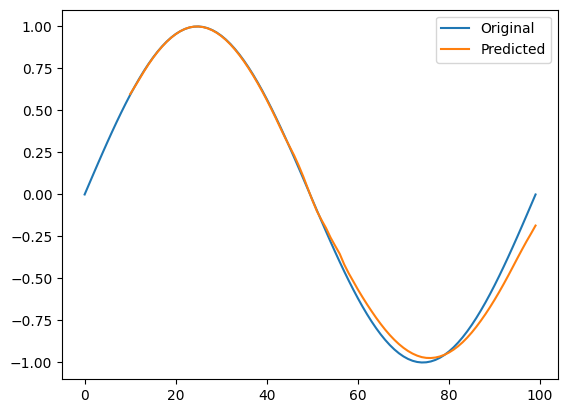

In [6]:
# Model
X = X.reshape((X.shape[0], X.shape[1], 1))
model = Sequential([
    SimpleRNN(50, activation='relu', input_shape=(time_window, 1)),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X, Y, epochs=20, batch_size=16, verbose=0)
predictions = model.predict(X)

#Plotting
plt.plot(time_steps, data, label='Original')
plt.plot(time_steps[time_window:], predictions, label='Predicted')
plt.legend()
plt.show()

## Building an LSTM Model
---

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


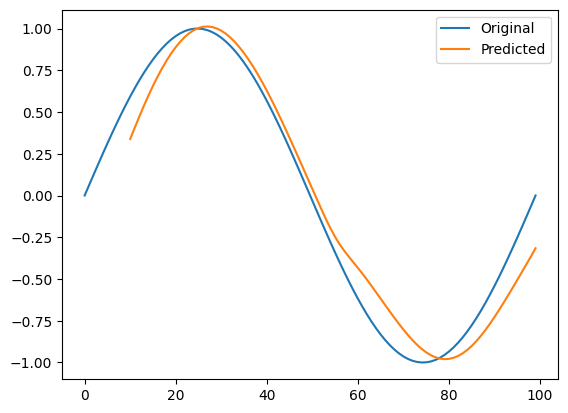

In [7]:
from tensorflow.keras.layers import LSTM

# Model
lstm_model = Sequential([
    LSTM(50, activation='relu', input_shape=(time_window, 1)),
    Dense(1)
])

lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(X, Y, epochs=20, batch_size=16, verbose=0)
lstm_predictions = lstm_model.predict(X)

# Plotting
plt.plot(time_steps, data, label='Original')
plt.plot(time_steps[time_window:], lstm_predictions, label='Predicted')
plt.legend()
plt.show()

# **Vision Transformers**


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Layer, Dense, LayerNormalization, Dropout, MultiHeadAttention, Flatten

class TransformerBlock(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(embed_dim),
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

# Define PatchEmbedding Layer
class PatchEmbedding(Layer):
    def __init__(self, num_patches, embedding_dim):
        super(PatchEmbedding, self).__init__()
        self.num_patches = num_patches
        self.embedding_dim = embedding_dim
        self.projection = Dense(embedding_dim)

    def call(self, patches):
        return self.projection(patches)

# Define Vision Transformer
class VisionTransformer(tf.keras.Model):
    def __init__(self, num_patches, embedding_dim, num_heads, ff_dim, num_layers, num_classes):
        super(VisionTransformer, self).__init__()
        self.patch_embed = PatchEmbedding(num_patches, embedding_dim)
        self.transformer_layers = [TransformerBlock(embedding_dim, num_heads, ff_dim) for _ in range(num_layers)]
        self.flatten = Flatten()
        self.dense = Dense(num_classes, activation='softmax')

    def call(self, images, training):
        patches = self.extract_patches(images)
        x = self.patch_embed(patches)
        for transformer_layer in self.transformer_layers:
            x = transformer_layer(x, training=training)
        x = self.flatten(x)
        return self.dense(x)

    def extract_patches(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(images, sizes= [1, 16, 16, 1], strides= [1, 16, 16, 1], rates= [1, 1, 1, 1], padding= 'VALID')
        patches = tf.reshape(patches, [batch_size, -1, 16 * 16 * 3])
        return patches

num_patches = 196 # Assuming 14x14 patches
embedding_dim = 128
num_heads = 4
ff_dim = 512
num_layers = 6
num_classes = 10 # For CIFAR-10 dataset

vit = VisionTransformer(num_patches, embedding_dim, num_heads, ff_dim, num_layers, num_classes)
images = tf.random.normal((32, 224, 224, 3))
outputs = vit(images, training=False)
print(outputs.shape)

# **Transformers in Speech Recognition**


In [29]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Dense, LayerNormalization, Dropout, Flatten, MultiHeadAttention, Conv1D, BatchNormalization, Reshape

class TransformerBlock(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.fnn = Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(embed_dim),
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training, mask=None):
      attn_output = self.att(inputs, inputs, inputs, attention_mask=mask)
      attn_output = self.dropout1(attn_output, training=training)
      out1 = self.layernorm1(inputs + attn_output)
      ffn_output = self.fnn(out1)
      ffn_output = self.dropout2(ffn_output, training=training)
      return self.layernorm2(out1 + ffn_output)

# Define PatchEmbedding Layer
class PatchEmbedding(Layer):
    def __init__(self, num_patches, embedding_dim):
        super(PatchEmbedding, self).__init__()
        self.num_patches = num_patches
        self.embedding_dim = embedding_dim
        self.projection = Dense(embedding_dim)

    def call(self, patches):
        return self.projection(patches)

class SpeechTransformer(Model):
    def __init__(self, num_patches, embedding_dim, num_heads, ff_dim, num_layers, num_classes):
        super(SpeechTransformer, self).__init__()
        self.conv1 = Conv1D(filters=embedding_dim, kernel_size=3, strides=1, padding='same', activation='relu')
        self.batch_norm = BatchNormalization()
        self.reshape = Reshape((-1, embedding_dim))
        self.transformer_layers = [TransformerBlock(embedding_dim, num_heads, ff_dim) for _ in range(num_layers)]
        self.flatten = Flatten()
        self.dense = Dense(num_classes, activation='softmax')

    def call(self, spectrograms):
        x = self.conv1(spectrograms)
        x = self.batch_norm(x)
        x = self.reshape(x)
        for transformer_layer in self.transformer_layers:
            x = transformer_layer(x, training=False)
        x = self.flatten(x)
        return self.dense(x)

num_mel_bins = 80
embedding_dim = 128
num_heads = 4
ff_dim = 512
num_layers = 6
num_classes = 30 # For Phoneme Classificaiton

st = SpeechTransformer(num_mel_bins, embedding_dim, num_heads, ff_dim, num_layers, num_classes)

spectograms = tf.random.normal((32, 100, num_mel_bins))
outputs = st(spectograms, training=False)
print(outputs.shape)

(32, 30)


# **Decision Transformers for RL**


In [30]:
from tensorflow.keras.layers import Dense, TimeDistributed

class TransformerBlock(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.fnn = Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(embed_dim),
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training, mask=None):
      attn_output = self.att(inputs, inputs, inputs, attention_mask=mask)
      attn_output = self.dropout1(attn_output, training=training)
      out1 = self.layernorm1(inputs + attn_output)
      ffn_output = self.fnn(out1)
      ffn_output = self.dropout2(ffn_output, training=training)
      return self.layernorm2(out1 + ffn_output)

class DesicisionTransformer(Model):
    def __init__(self, state_dim, action_dim, embedding_dim, num_heads, ff_dim, num_layers):
        super(DesicisionTransformer, self).__init__()
        self.state_embed = Dense(embedding_dim, activation='relu')
        self.action_embed = Dense(embedding_dim, activation='relu')
        self.transformer_layers = [TransformerBlock(embedding_dim, num_heads, ff_dim) for _ in range(num_layers)]
        self.dense = TimeDistributed(Dense(action_dim))

    def call(self, states, actions):
        state_embeddings = self.state_embed(states)
        action_embeddings = self.action_embed(actions)
        x = state_embeddings + action_embeddings
        for transformer_layer in self.transformer_layers:
            x = transformer_layer(x, training=False)
        return self.dense(x)

state_dim = 20
action_dim = 5
embedding_dim = 128
num_heads = 4
ff_dim = 512
num_layers = 6

dt = DesicisionTransformer(state_dim, action_dim, embedding_dim, num_heads, ff_dim, num_layers)

states = tf.random.normal((32, 10, state_dim))
actions = tf.random.normal((32, 10, action_dim))
outputs = dt(states, actions, training=False)
print(outputs.shape)

(32, 10, 5)
